<center>
<img src="../../img/ods_stickers.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Author: [Yury Kashnitsky](https://www.linkedin.com/in/festline/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

## <center> Assignment 4 (demo). Solution
### <center>  Sarcasm detection with logistic regression
    
**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit) + [solution](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit-solution).**


We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

In [ ]:
PATH_TO_DATA = "../input/sarcasm/train-balanced-sarcasm.csv"

In [1]:
PATH_TO_DATA = "/Users/rakhmangulovs/Downloads/archive-4/train-balanced-sarcasm.csv"

In [2]:
# some necessary imports
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
train_df = pd.read_csv(PATH_TO_DATA)

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
train_df.dropna(subset=["comment"], inplace=True)

We notice that the dataset is indeed balanced

In [8]:
train_df["label"].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [9]:
train_texts, valid_texts, y_train, y_valid = train_test_split(
    train_df["comment"], train_df["label"], random_state=17
)

In [10]:
y_valid

469600    0
639137    0
240293    0
702254    1
889040    1
         ..
23988     0
408769    1
688966    0
107936    1
767875    1
Name: label, Length: 252694, dtype: int64

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

### Part 1. Exploratory data analysis

Distribution of lengths for sarcastic and normal comments is almost the same.

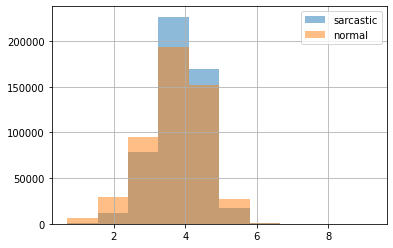

In [11]:
train_df.loc[train_df["label"] == 1, "comment"].str.len().apply(np.log1p).hist(
    label="sarcastic", alpha=0.5
)
train_df.loc[train_df["label"] == 0, "comment"].str.len().apply(np.log1p).hist(
    label="normal", alpha=0.5
)
plt.legend();

In [14]:
pip install wordcloud

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 220 kB 1.4 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp39-cp39-macosx_12_0_arm64.whl size=153835 sha256=219ff78559839ce468473c435b42bdd93a65327295de594c86ef85f51888dbc8
  Stored in directory: /Users/rakhmangulovs/Library/Caches/pip/wheels/f9/7a/dd/06ef8b5dfe5483f6204133c08eeb16c287cc2c05e290ae2fc0
Successfully built wordcloud
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/

In [15]:
from wordcloud import STOPWORDS, WordCloud

In [16]:
wordcloud = WordCloud(
    background_color="black",
    stopwords=STOPWORDS,
    max_words=200,
    max_font_size=100,
    random_state=17,
    width=800,
    height=400,
)

Word cloud are nice, but not very useful

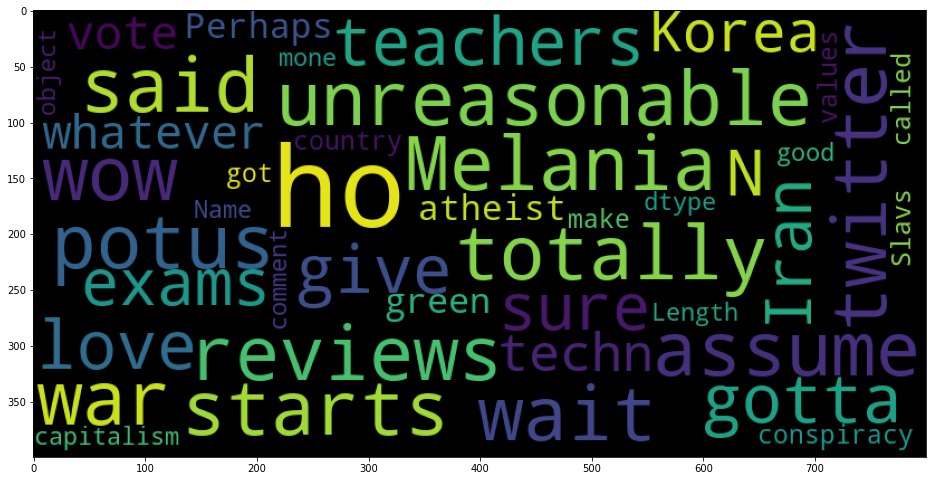

In [17]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df["label"] == 1, "comment"]))
plt.imshow(wordcloud);

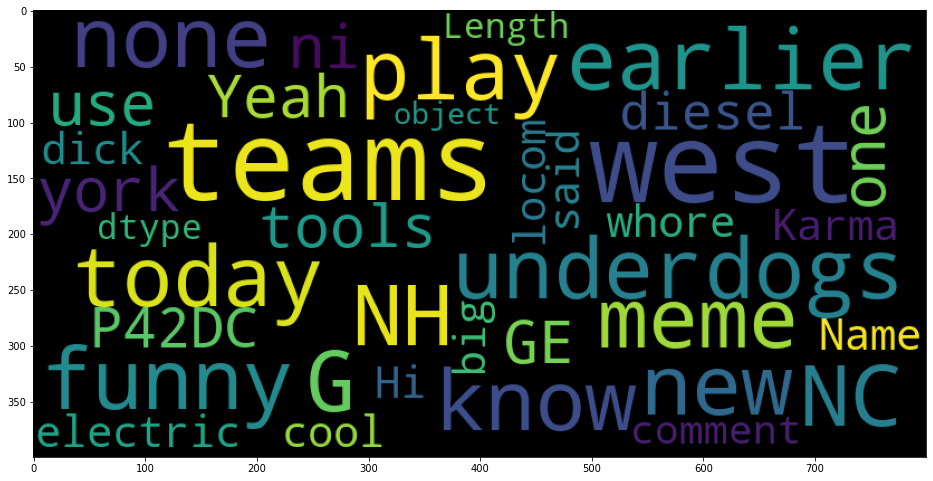

In [18]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df["label"] == 0, "comment"]))
plt.imshow(wordcloud);

Let's analyze whether some subreddits are more "sarcastic" on average than others

In [19]:
sub_df = train_df.groupby("subreddit")["label"].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by="sum", ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [20]:
sub_df[sub_df["size"] > 1000].sort_values(by="mean", ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


The same for authors doesn't yield much insight. Except for the fact that somebody's comments were sampled - we can see the same amounts of sarcastic and non-sarcastic comments.

In [21]:
sub_df = train_df.groupby("author")["label"].agg([np.size, np.mean, np.sum])
sub_df[sub_df["size"] > 300].sort_values(by="mean", ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [23]:
sub_df = (
    train_df[train_df["score"] >= 0]
    .groupby("score")["label"]
    .agg([np.size, np.mean, np.sum])
)
sub_df[sub_df["size"] > 300].sort_values(by="mean", ascending=False).head(10)

,size,mean,sum
score,,,
0,58141,0.612752,35626
20,3096,0.561370,1738
34,1071,0.556489,596
26,1874,0.554429,1039
59,315,0.552381,174
18,3951,0.551759,2180
13,7277,0.546929,3980
17,4404,0.545867,2404
40,722,0.545706,394


In [25]:
sub_df = (
    train_df[train_df["score"] < 0]
    .groupby("score")["label"]
    .agg([np.size, np.mean, np.sum])
)
sub_df[sub_df["size"] > 300].sort_values(by="mean", ascending=False).head(10)

,size,mean,sum
score,,,
-14,537,0.698324,375
-8,1852,0.696004,1289
-9,1503,0.691284,1039
-6,3088,0.688795,2127
-12,776,0.684278,531
-5,4134,0.678520,2805
-3,6736,0.676069,4554
-2,11924,0.675948,8060
-4,5436,0.673473,3661


### Part 2. Training the model

In [26]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=-1, solver="lbfgs", random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([("tf_idf", tf_idf), ("logit", logit)])

In [29]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        50001     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25460D+05    |proj g|=  1.32078D+03


 This problem is unconstrained.



At iterate   50    f=  4.09699D+05    |proj g|=  1.82935D+03

At iterate  100    f=  4.05779D+05    |proj g|=  2.14573D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
50001    100    114      1     0     0   2.146D+02   4.058D+05
  F =   405778.66317353124     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
CPU times: user 11.4 s, sys: 336 ms, total: 11.8 s
Wall time: 17.1 s


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.2s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [30]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

CPU times: user 2.46 s, sys: 35.2 ms, total: 2.5 s
Wall time: 2.5 s


In [31]:
accuracy_score(y_valid, valid_pred)

0.7211251553262048

### Part 3. Explaining the model

In [35]:
def plot_confusion_matrix(
    actual,
    predicted,
    classes,
    normalize=False,
    title="Confusion matrix",
    figsize=(7, 7),
    cmap=plt.cm.Blues,
    path_to_save_fig=None,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("Predicted label")
    plt.xlabel("True label")

    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches="tight")

Confusion matrix is quite balanced.

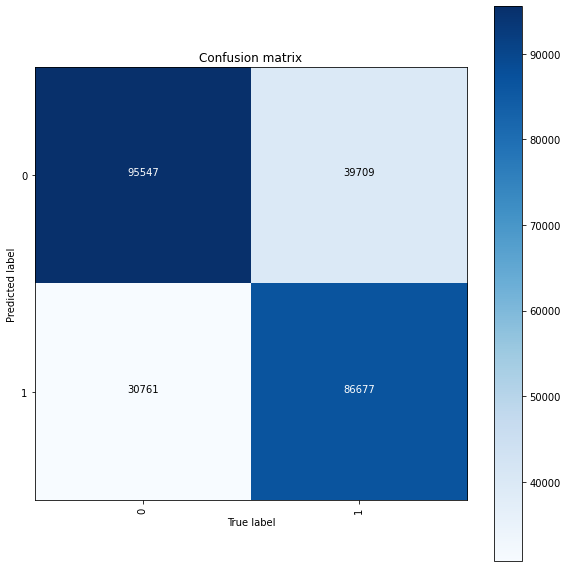

In [34]:
plot_confusion_matrix(
    y_valid,
    valid_pred,
    tfidf_logit_pipeline.named_steps["logit"].classes_,
    figsize=(8, 8),
)

Indeed, we can recognize some phrases indicative of sarcasm. Like "yes sure". 

In [37]:
pip install eli5

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 216 kB 1.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=937d1a314510f85c0812f1e8ae5f6448aa33ff2860dd20f06f0a46d74debd097
  Stored in directory: /Users/rakhmangulovs/Library/Caches/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils con

In [38]:
import eli5

eli5.show_weights(
    estimator=tfidf_logit_pipeline.named_steps["logit"],
    vec=tfidf_logit_pipeline.named_steps["tf_idf"],
)

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+9.236,yes because
+7.551,clearly
+7.233,yeah because
+7.150,obviously
+6.606,totally
+6.412,because
+6.015,how dare
+5.875,right because
+5.317,but thought
+5.266,duh


So sarcasm detection is easy.
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

### Part 4. Improving the model

In [39]:
subreddits = train_df["subreddit"]
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

We'll have separate Tf-Idf vectorizers for comments and for subreddits. It's possible to stick to a pipeline as well, but in that case it becomes a bit less straightforward. [Example](https://stackoverflow.com/questions/36731813/computing-separate-tfidf-scores-for-two-different-columns-using-sklearn)

In [40]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

Do transformations separately for comments and subreddits. 

In [41]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

CPU times: user 13.9 s, sys: 335 ms, total: 14.2 s
Wall time: 14.3 s


In [42]:
X_train_texts.shape, X_valid_texts.shape

((758079, 50000), (252694, 50000))

In [43]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

CPU times: user 1.28 s, sys: 16.5 ms, total: 1.3 s
Wall time: 1.3 s


In [44]:
X_train_subreddits.shape, X_valid_subreddits.shape

((758079, 13255), (252694, 13255))

Then, stack all features together.

In [46]:
from scipy.sparse import hstack

X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [47]:
X_train.shape, X_valid.shape

((758079, 63255), (252694, 63255))

Train the same logistic regression.

In [48]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        63256     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25460D+05    |proj g|=  4.94750D+03

At iterate   50    f=  4.17074D+05    |proj g|=  3.16379D+03

At iterate  100    f=  4.03900D+05    |proj g|=  7.39046D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
63256    100    114      1     0     0   7.390D+02   4.039D+05
  F =   403899.93290804379     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.4s finished


LogisticRegression(C=1, n_jobs=4, random_state=17, verbose=1)

In [49]:
%%time
valid_pred = logit.predict(X_valid)

CPU times: user 17.9 ms, sys: 5.3 ms, total: 23.2 ms
Wall time: 20.2 ms


In [50]:
accuracy_score(y_valid, valid_pred)

0.7237686688247446

As we can see, accuracy slightly increased.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions